In [1]:
import pandas
import numpy

In [11]:
from matplotlib import pyplot
import matplotlib
%matplotlib inline
matplotlib.style.use("ggplot")
matplotlib.rcParams["figure.figsize"] = (10, 10)

In [2]:
data = pandas.read_csv("Sample_data.csv")
data

,Sample_01,Sample_02,Sample_03
0,-0.057373,-0.033264,-0.004883
1,-0.057983,-0.034485,-0.002747
2,-0.058289,-0.033875,-0.003967
3,-0.058594,-0.035095,-0.000916
4,-0.059204,-0.034790,-0.004578
...,...,...,...
59995,-0.133057,-0.030823,-0.006714
59996,-0.130920,-0.030823,-0.008545
59997,-0.134583,-0.030823,-0.006409
59998,-0.133362,-0.030212,-0.007019


In [82]:
def get_noise_range(dataset, scaling_n=1):
    """
    Checks the first 100 data points.
    For now it checks if the maximal value is less than 3 SDs away from the mean. 
    """
    subdata = dataset[:100//scaling_n]
    _mean = subdata.mean()
    _std = subdata.std()
    _max = subdata.max()
    if _max - _mean < 3*_std:
        return abs(_max - _mean)
    else:
        return -1


In [83]:
noise_levels = data.apply(get_noise_range, axis=0)
noise_levels

Sample_01    0.003418
Sample_02    0.002264
Sample_03    0.003876
dtype: float64

In [183]:
def reduce_trace(dataset, method="decimate", n=1, keep_len=False):
    """"
    If method is decimate n is the number telling the distance between the retained points.
    If method is sub_average n tells the alghoritm how many data points it needs to average out. Note this approach smoothens out the data and reduces high frequency noise. 
    """
    if method == "decimate":
        dataset2 =  dataset[::n]
    elif method == "sub_average":
        if len(dataset) % n == 0:
            dataset2 = dataset.reshape((-1, 5)).mean(axis=1)
        else:
            dataset2 = numpy.concatenate((dataset[:-(len(dataset)%n)].reshape((-1, 5)).mean(axis=1), [dataset[-(len(dataset)%n):].mean()]))
    if keep_len:
        empty_array = numpy.empty((len(dataset) - len(dataset2)))
        empty_array[:] = numpy.nan
        dataset2 = numpy.concatenate((dataset2, empty_array))
    return dataset2

In [85]:
reduced_traces = data.apply(lambda x: reduce_trace(x, method="decimate", n=10), axis=0)
reduced_traces

,Sample_01,Sample_02,Sample_03
0,-0.057373,-0.033264,-0.004883
10,-0.054626,-0.033264,-0.004272
20,-0.056458,-0.033875,-0.004578
30,-0.057068,-0.033569,-0.004272
40,-0.057373,-0.033264,-0.003967
...,...,...,...
59950,-0.133362,-0.030823,-0.003967
59960,-0.133362,-0.031738,-0.004883
59970,-0.132751,-0.031738,-0.005493
59980,-0.133057,-0.031433,-0.004883


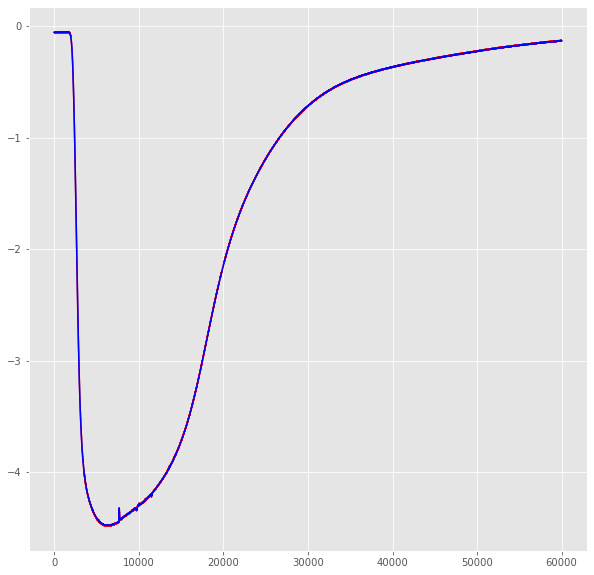

In [86]:
pyplot.plot(data["Sample_01"], c="red")
pyplot.plot(reduced_traces["Sample_01"], c="blue")
pyplot.show()

In [87]:
reduced_traces.reset_index(inplace=True, drop=True)

In [88]:
def scale_trace(dataset, noise, positive=False, scaling_n=1):
    """"
    Scales the trace so the baseline is at 0 and the max-noise is at 1.
    Note if the amplitude of the trace increases to the positive numbers, switch positive to True.
    Scaling_n specifies the scaling factor for reducing the number of initial datapoints taken into account for baseline adjustment.
    """
    if positive:
        dataset = dataset-abs(dataset[:100//scaling_n].min()+noise)
        return dataset / abs(dataset.max()-noise)
    else:
        dataset = dataset+abs(dataset[:100//scaling_n].max()-noise)
        return dataset / abs(dataset.min()+noise)

In [89]:
reduced_noise = reduced_traces.apply(lambda x: get_noise_range(x, scaling_n=10), axis=0)
reduced_noise

Sample_01    0.002136
Sample_02    0.000763
Sample_03    0.000458
dtype: float64

In [90]:
scaled_reduced = reduced_traces.apply(lambda x: scale_trace(x, noise=reduced_noise[x.name], scaling_n=10), axis=0)
scaled_reduced

,Sample_01,Sample_02,Sample_03
0,-0.000138,0.000036,-0.000111
1,0.000484,0.000036,0.000037
2,0.000069,-0.000109,-0.000037
3,-0.000069,-0.000036,0.000037
4,-0.000138,0.000036,0.000111
...,...,...,...
5995,-0.017341,0.000618,0.000111
5996,-0.017341,0.000400,-0.000111
5997,-0.017203,0.000400,-0.000259
5998,-0.017272,0.000473,-0.000111


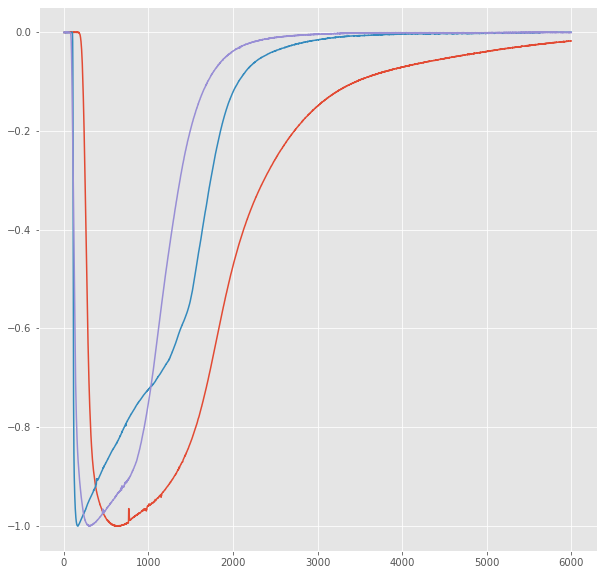

In [92]:
for col in scaled_reduced.columns:
    pyplot.plot(scaled_reduced[col])
pyplot.show()

In [102]:
def find_anchors(dataset, cutoff, scaling_n=1, positive=False):
    """
    Finds two anchorpoints and returns them as a tuple:
        - The point where the data goes beyond a percentage-of-peak cutoff
        - the maximum point
    Data is assumed to already be scaled so it goes between 0 and 1/-1 (depending on the value of positive).
    """
    if positive:
        return numpy.argmax(dataset > cutoff), numpy.argmax(dataset)
    else:
        return numpy.argmax(dataset < (-1 * cutoff)), numpy.argmin(dataset)

In [111]:
anchors = scaled_reduced.apply(lambda x: find_anchors(x, 0.01), axis=0)
anchors["Index"] = ["Treshold", "Max"]
anchors.set_index(["Index"], inplace=True)
anchors

,Sample_01,Sample_02,Sample_03
Index,,,
Treshold,197,103,85
Max,630,161,304


In [163]:
def adjust_trace(dataset, trace_anchors, reference_anchors):
    dataset = dataset[trace_anchors["Treshold"] - reference_anchors["Treshold"]:].append(pandas.Series(numpy.NaN, index=list(range(trace_anchors["Treshold"] - reference_anchors["Treshold"]))), ignore_index=True)
    return dataset

In [218]:
def adjust_traces(data, anchors, keep_len=False):
    """"
    When keep_len is true the prunning of NaN-containing rows is not performed. 
    """
    reference_anchors = anchors[anchors.columns[anchors.loc["Treshold"].argmin()]]
    data = data.apply(lambda x: adjust_trace(x, anchors[x.name], reference_anchors), axis=0)
    if not keep_len:
        data.dropna(axis=0, how="any", inplace=True)
    return data

In [171]:
adjusted_traces = adjust_traces(scaled_reduced, anchors)

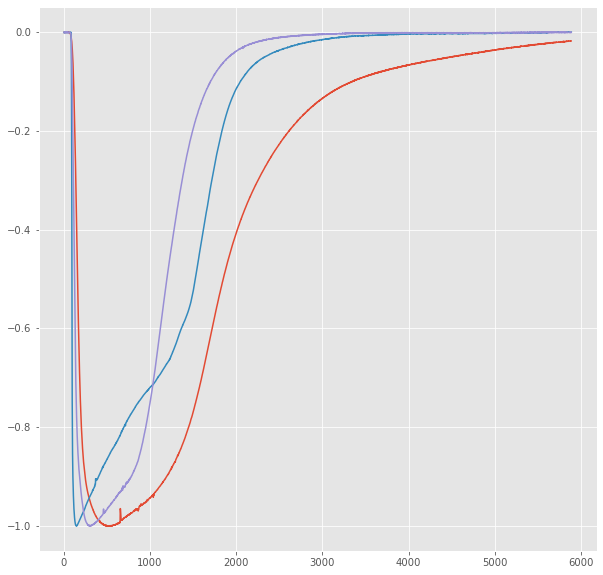

In [173]:
for col in adjusted_traces.columns:
    pyplot.plot(adjusted_traces[col])
pyplot.show()

In [184]:
anchors_test = anchors.loc["Max"] - anchors.loc["Treshold"]
reference = anchors.columns[anchors_test.argmin()]
scales = anchors_test / anchors_test[reference]
scales["Sample_02"]

1.0

In [230]:
_final_len = 3000

In [260]:
# Get noise levels
noise_levels = data.apply(get_noise_range, axis=0)
# Scale from 0 to 1
scaled_data = data.apply(lambda x: scale_trace(x, noise_levels[x.name]), axis=0)
# Find anchor points
anchors = scaled_data.apply(lambda x: find_anchors(x, 0.01), axis=0)
anchors["Index"] = ["Treshold", "Max"]
anchors.set_index(["Index"], inplace=True)
# Find the scaling factors
anchors_difference = anchors.loc["Max"] - anchors.loc["Treshold"]
reference = anchors.columns[anchors_difference.argmin()]
scaling_factors = anchors_difference // anchors_difference[reference]
# Rescale by reduction
reduced_traces = scaled_data.apply(lambda x: reduce_trace(x, method="decimate", n=scaling_factors[x.name], keep_len=True), axis=0)
# reduced_traces.dropna(axis=0, how="any", inplace=True)
# Recalculate the anchors
anchors = reduced_traces.apply(lambda x: find_anchors(x, 0.01), axis=0)
anchors["Index"] = ["Treshold", "Max"]
anchors.set_index(["Index"], inplace=True)
# Adjust the traces
adjusted_data = adjust_traces(reduced_traces, anchors, keep_len=False)
# Prune the data again to fit the final length
final_data = adjusted_data.apply(lambda x: reduce_trace(x, method="decimate", n=len(x)//_final_len, keep_len=False), axis=0)
final_data.reset_index(inplace=True, drop=True)
final_data = final_data[:_final_len]

In [261]:
adjusted_data

,Sample_01,Sample_02,Sample_03
0,0.000152,0.000249,-0.000022
1,-0.000193,0.000249,0.000940
2,-0.000331,-0.000042,-0.000244
3,0.000290,0.000103,-0.000022
4,0.000428,-0.000261,0.000348
...,...,...,...
8567,-0.016971,-0.737787,-0.008908
8568,-0.016626,-0.737496,-0.008982
8569,-0.016350,-0.737787,-0.008612
8570,-0.016971,-0.737933,-0.008686


In [262]:
final_data

,Sample_01,Sample_02,Sample_03
0,0.000152,0.000249,-0.000022
1,-0.000331,-0.000042,-0.000244
2,0.000428,-0.000261,0.000348
3,0.000014,0.000103,-0.000689
4,-0.000331,0.000686,-0.000170
...,...,...,...
2995,-0.062816,-0.814721,-0.072294
2996,-0.062954,-0.815158,-0.071405
2997,-0.062609,-0.815230,-0.071998
2998,-0.062609,-0.814430,-0.071776


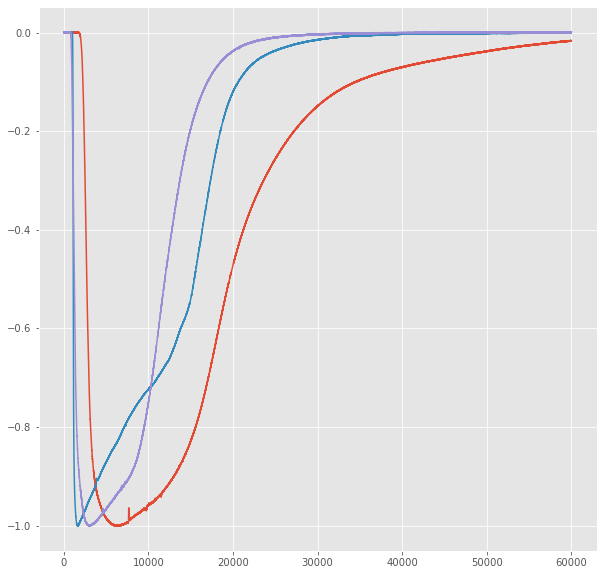

In [263]:
for col in scaled_data.columns:
    pyplot.plot(scaled_data[col])
pyplot.show()

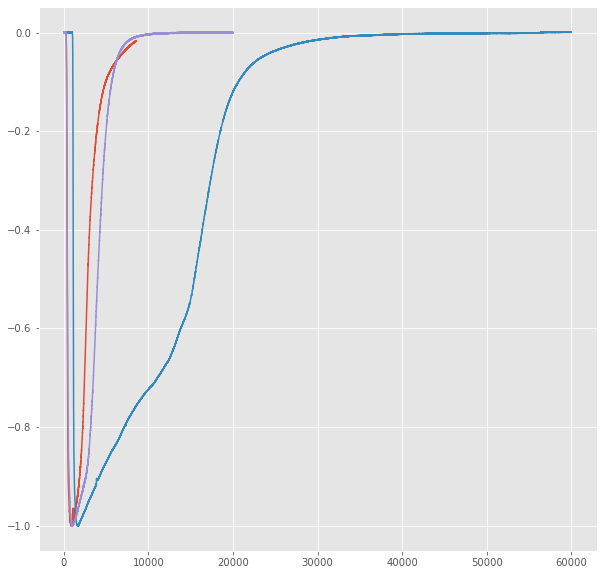

In [264]:
for col in reduced_traces.columns:
    pyplot.plot(reduced_traces[col])
pyplot.show()

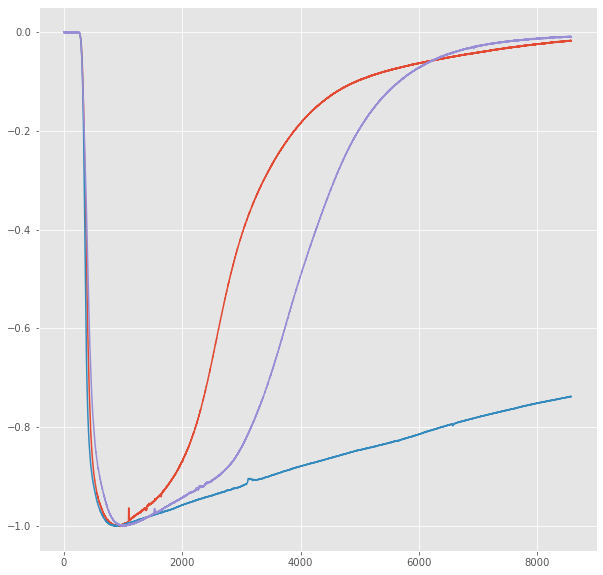

In [265]:
for col in adjusted_data.columns:
    pyplot.plot(adjusted_data[col])
pyplot.show()

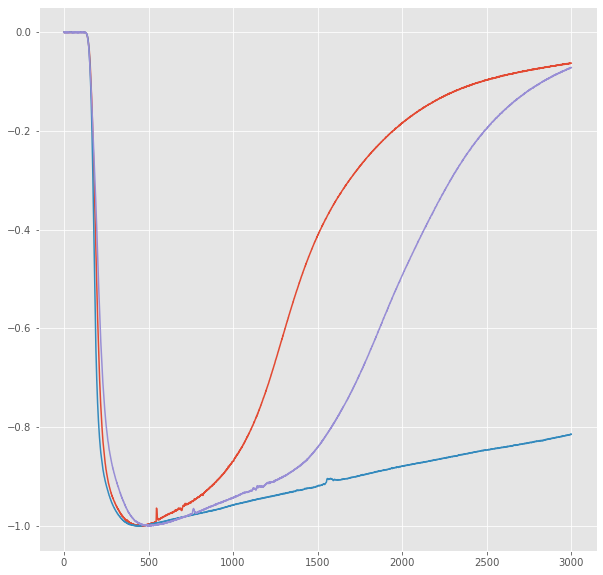

In [266]:
for col in final_data.columns:
    pyplot.plot(final_data[col])
pyplot.show()

# Playing with plotting

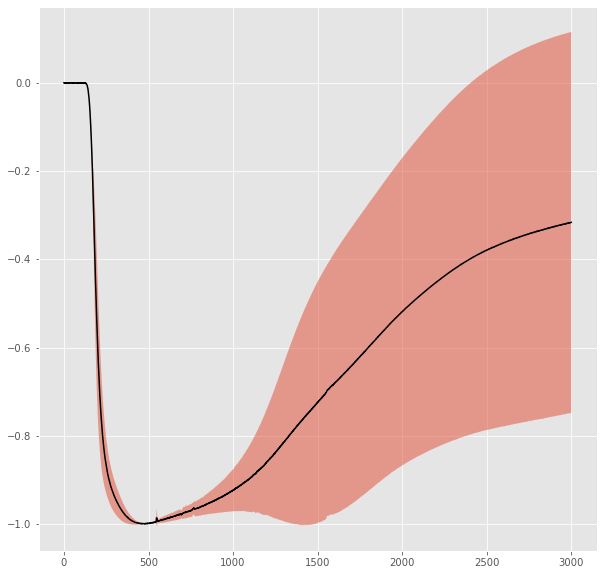

In [274]:
y = final_data.mean(axis=1)
error = final_data.std(axis=1)


pyplot.plot(list(range(len(y))), y, "-k")
pyplot.fill_between(list(range(len(y))), y-error, y+error, alpha=0.5)
pyplot.show()